In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

from utils.classing import get_target_by_classing
from utils.data import FilePaths, display_image, read_image_file, rmse
from utils.deep import (
    RegressionDataset,
    Regressor,
    ToTensor,
    stack_inputs,
    train
)
from utils.models import (
    albedo_polynomial_fit,
    albedo_polynomial_sharpening,
    linear_fit,
    linear_sharpening,
    multi_linear_fit,
    multi_linear_sharpening,
)
from utils.patching import get_fine_reconstruction_from_patches
from utils.residualcorrection import (
    upscale_coarse,
    upscale_coarse_krig,
    resid_calc_classic,
    resid_calc_mean
)

In [2]:
n_c = 30
n_h = 150

In [3]:
I_C = read_image_file(FilePaths.INDEX_C)
I_H = read_image_file(FilePaths.INDEX_H)
T_C = read_image_file(FilePaths.TEMP_C)
T_H = read_image_file(FilePaths.TEMP_H)
A_C = read_image_file(FilePaths.ALBEDO_C)
A_H = read_image_file(FilePaths.ALBEDO_H)
C_C = read_image_file(FilePaths.CLASS_C)
C_H = read_image_file(FilePaths.CLASS_H)

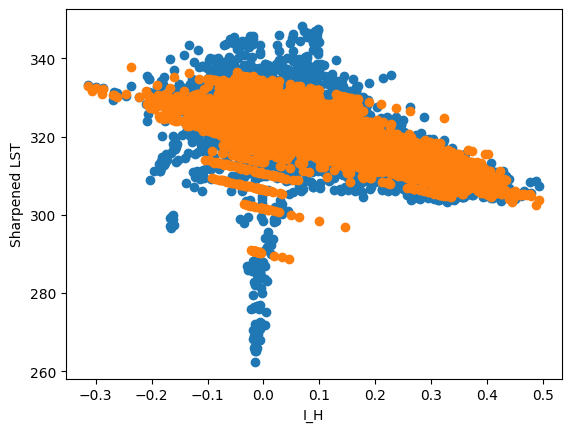

In [40]:
import matplotlib.pyplot as plt

plt.scatter(I_H,T_H)
plt.scatter(I_H,linear_sharp_rc_linaer)
plt.xlabel('I_H')
plt.ylabel('Sharpened LST')
plt.show()
#ax3.set_ylim((260,350))

In [54]:
import plotly.graph_objects as go

scatter_th = go.Scatter3d(
    x=I_H.ravel(), y=A_H.ravel(), z=T_H.ravel(),
    mode='markers',
    marker=dict(size=4, color='blue'),
    name='T_H'
)

scatter_sharp = go.Scatter3d(
    x=I_H.ravel(), y=A_H.ravel(), z=multi_sharp_rc_linear.ravel(),
    mode='markers',
    marker=dict(size=4, color='red'),
    name='Sharpened LS'
)

fig = go.Figure(data=[scatter_th, scatter_sharp])
fig.update_layout(
    scene=dict(
        xaxis_title='I_H',
        yaxis_title='A_H',
        zaxis_title='Value'
    ),
    title='3D Scatter Comparison',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()

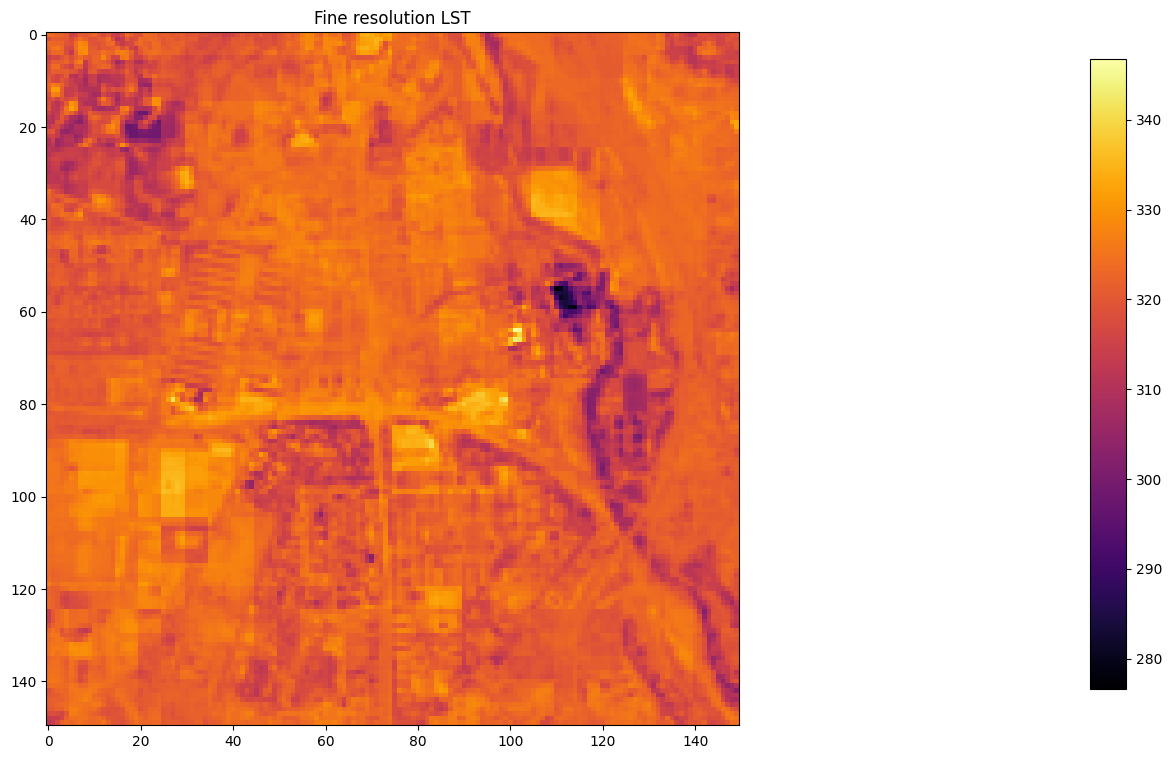

In [23]:
display_image(multi_patched_rc_linear)

In [9]:
ALBEDO_LOW = T_C.min() - 5
ALBEDO_HIGH = T_C.max() + 5

## Linear Fit

In [10]:
linear_fit_res = linear_fit(I_C, T_C)

linear_pred = linear_sharpening([I_C], linear_fit_res)
linear_sharp = linear_sharpening([I_H], linear_fit_res)

linear_resids = resid_calc_classic(T_C, linear_pred)

upscaled_linear_linear_resids = upscale_coarse(linear_resids)
upscaled_linear_krig_resids = upscale_coarse_krig(linear_resids)

linear_sharp_rc_linaer = linear_sharp + upscaled_linear_linear_resids
linear_sharp_rc_krig   = linear_sharp + upscaled_linear_krig_resids

linear_rc_linear_rmse = rmse(linear_sharp_rc_linaer, T_H)
linear_rc_krig = rmse(linear_sharp_rc_krig, T_H)

print("Linear Model RMSEs")
print("Residual Correction - Linear : ", linear_rc_linear_rmse)
print("Residual Correction - Krig   : ", linear_rc_krig)

Linear Model RMSEs
Residual Correction - Linear :  9.177208550747284
Residual Correction - Krig   :  9.741766828649471


## Multi-Linear Fit

In [14]:
multi_model = multi_linear_fit([I_C, A_C], T_C)

multi_pred = multi_linear_sharpening([I_C.flatten(), A_C.flatten()], multi_model, n_c)
multi_sharp = multi_linear_sharpening([I_H.flatten(), A_H.flatten()], multi_model, n_h)

multi_resids = resid_calc_classic(T_C, multi_pred)

upscaled_multi_linear_resids = upscale_coarse(multi_resids)
upscaled_multi_krig_resids = upscale_coarse_krig(multi_resids)

multi_sharp_rc_linear = multi_sharp + upscaled_multi_linear_resids
multi_sharp_rc_krig = multi_sharp + upscaled_multi_krig_resids


multi_rc_linear_rmse = rmse(multi_sharp_rc_linear, T_H)
multi_rc_krig = rmse(multi_sharp_rc_krig, T_H)

print("Multi Linear Model RMSEs")
print("Residual Correction - Linear : ", multi_rc_linear_rmse)
print("Residual Correction - Krig   : ", multi_rc_krig)

Multi Linear Model RMSEs
Residual Correction - Linear :  9.60510883824584
Residual Correction - Krig   :  21.761528665589697


## Polynomial Fit

In [17]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def distance_weighted_mean_filter(image, threshold_high, thershold_low, window_size=5):
    assert window_size % 2 == 1, "Window size must be odd."
    pad = window_size // 2
    padded_image = np.pad(image, pad, mode='reflect')  # handle edges

    y, x = np.mgrid[-pad:pad+1, -pad:pad+1]
    distances = np.sqrt(x**2 + y**2)
    with np.errstate(divide='ignore'):
        weights = 1 / (distances + 1e-6)  # avoid divide by zero
    weights /= weights.sum()  # normalize weights

    modified = image.copy()
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (
                threshold_high < image[i, j]
                or image[i, j] < thershold_low
            ):
                window = padded_image[i:i+window_size, j:j+window_size]
                weighted_mean = np.sum(window * weights)
                modified[i, j] = weighted_mean

    return modified




In [18]:
from utils.models import albedo_polynomial, replace_thresholded_pixels


X = albedo_polynomial(*[I_C, A_C])
res = poly_model.predict(X)
if res.min() < ALBEDO_LOW or res.min() > ALBEDO_HIGH:
    print('GO')
    res = replace_thresholded_pixels(res, albedo_high, albedo_low)

NameError: name 'poly_model' is not defined

In [19]:
poly_model = albedo_polynomial_fit([I_C, A_C], T_C)

poly_pred = albedo_polynomial_sharpening([I_C, A_C], poly_model, n_c, ALBEDO_HIGH, ALBEDO_LOW)
poly_sharp = albedo_polynomial_sharpening([I_H, A_H], poly_model, n_h, ALBEDO_HIGH, ALBEDO_LOW)

poly_resids = resid_calc_mean(T_C, poly_sharp)

upscaled_poly_linear_resids = upscale_coarse(poly_resids)
upscaled_poly_krig_resids = upscale_coarse_krig(poly_resids)

poly_sharp_rc_linear = poly_sharp + upscaled_poly_linear_resids
poly_sharp_rc_krig = poly_sharp + upscaled_poly_krig_resids

poly_rc_linear_rmse = rmse(poly_sharp_rc_linear, T_H)
poly_rc_krig = rmse(poly_sharp_rc_krig, T_H)

print("Albedo Polynomial Model RMSEs")
print("Residual Correction - Linear : ", poly_rc_linear_rmse)
print("Residual Correction - Krig   : ", poly_rc_krig)

IndexError: tuple index out of range

## Patching

In [20]:
patch_size = 5
stride = patch_size
coarse_image_temp = T_C

#### Linear Patching

In [21]:
lin_coarse_inputs = [I_C]
lin_fine_inputs = [I_H]

linear_patched, linear_patched_resids = get_fine_reconstruction_from_patches(
    lin_coarse_inputs, lin_fine_inputs, coarse_image_temp, linear_fit, linear_sharpening, patch_size, stride,
)

linear_patched_rc_linear = linear_patched + upscale_coarse(linear_patched_resids)
linear_patched_rc_krig = linear_patched + upscale_coarse_krig(linear_patched_resids)

lin_patched_rc_linear_rmse = rmse(linear_patched_rc_linear, T_H)
lin_patched_rc_krig_rmse = rmse(linear_patched_rc_krig, T_H)

print("Linear Patched Model RMSEs")
print("Residual Correction - Linear : ", lin_patched_rc_linear_rmse)
print("Residual Correction - Krig   : ", lin_patched_rc_krig_rmse)

Linear Patched Model RMSEs
Residual Correction - Linear :  9.860210475391769
Residual Correction - Krig   :  15.647707829282272


#### Multi Linear Patching

In [22]:
multi_coarse_inputs = [I_C, A_C]
multi_fine_inputs = [I_H, A_H]

multi_patched, multi_patched_resids = get_fine_reconstruction_from_patches(
    multi_coarse_inputs, multi_fine_inputs, coarse_image_temp, multi_linear_fit, multi_linear_sharpening, patch_size, stride,
)

multi_patched_rc_linear = multi_patched + upscale_coarse(multi_patched_resids)
multi_patched_rc_krig = multi_patched + upscale_coarse_krig(multi_patched_resids)


multi_patched_rc_linear_rmse = rmse(multi_patched_rc_linear, T_H)
multi_patched_rc_krig_rmse = rmse(multi_patched_rc_krig, T_H)

print("Multi Patched Model RMSEs")
print("Residual Correction - Linear : ", multi_patched_rc_linear_rmse)
print("Residual Correction - Krig   : ", multi_patched_rc_krig_rmse)

Multi Patched Model RMSEs
Residual Correction - Linear :  9.654868025514062
Residual Correction - Krig   :  14.29652704867315


#### Polynomial Patching

In [24]:
poly_coarse_inputs = [I_C, A_C]
poly_fine_inputs = [I_H, A_H]

poly_patched, poly_patched_resids = get_fine_reconstruction_from_patches(
    poly_coarse_inputs, poly_fine_inputs, coarse_image_temp,
    albedo_polynomial_fit, albedo_polynomial_sharpening,
    patch_size, stride, ALBEDO_HIGH, ALBEDO_LOW
)

poly_patched_rc_linear = poly_patched + upscale_coarse(poly_patched_resids)
poly_patched_rc_krig = poly_patched + upscale_coarse_krig(poly_patched_resids)

poly_patched_rc_linear_rmse = rmse(poly_patched_rc_linear, T_H)
poly_patched_rc_krig_rmse = rmse(poly_patched_rc_krig, T_H)

print("Poly Patched Model RMSEs")
print("Residual Correction - Linear : ", poly_patched_rc_linear_rmse)
print("Residual Correction - Krig   : ", poly_patched_rc_krig_rmse)

IndexError: tuple index out of range

## Classing

In [25]:
coarse_image_temp = T_C

classes = np.unique(C_C)
coarse_masks = {}
fine_masks = {}

for class_ in classes:
    coarse_masks[class_] = C_C == class_
    fine_masks[class_] = C_H == class_


#### Linear Classing

In [26]:
lin_coarse_inputs = [I_C]
lin_fine_inputs = [I_H]

linear_classed, linear_classes_resids = get_target_by_classing(
    lin_coarse_inputs, lin_fine_inputs, coarse_image_temp, coarse_masks, fine_masks, linear_fit, linear_sharpening,
)

lin_classed_rc_linear = linear_classed + upscale_coarse(linear_classes_resids)
lin_classed_rc_krig = linear_classed + upscale_coarse_krig(linear_classes_resids)

lin_classed_rc_linear_rmse = rmse(lin_classed_rc_linear, T_H)
lin_classed_rc_krig_rmse = rmse(lin_classed_rc_krig, T_H)

print("Linear Classed Model RMSEs")
print("Residual Correction - Linear : ", lin_classed_rc_linear_rmse)
print("Residual Correction - Krig   : ", lin_classed_rc_krig_rmse)

Linear Classed Model RMSEs
Residual Correction - Linear :  11.634007908299235
Residual Correction - Krig   :  12.304131679321127


RMSE by Class

In [27]:
sharp_class1 = lin_classed_rc_linear[fine_masks[-100]]
T_H_class1 = T_H[fine_masks[-100]]

sharp_class2 = lin_classed_rc_linear[fine_masks[100]]
T_H_class2 = T_H[fine_masks[100]]

sharp_class3 = lin_classed_rc_linear[fine_masks[200]]
T_H_class3 = T_H[fine_masks[200]]

print("Linear Classed Model RMSEs by Class")
print("RMSE Class 1 : ", rmse(sharp_class1, T_H_class1))
print("RMSE Class 2 : ", rmse(sharp_class2, T_H_class2))
print("RMSE Class 3 : ", rmse(sharp_class3, T_H_class3))

Linear Classed Model RMSEs by Class
RMSE Class 1 :  18.451799036648907
RMSE Class 2 :  7.533752975333412
RMSE Class 3 :  12.734455418761495


Multi Linear Classing

In [28]:
multi_coarse_inputs = [I_C, A_C]
multi_fine_inputs = [I_H, A_H]

multi_classed, multi_classes_resids = get_target_by_classing(
    multi_coarse_inputs, multi_fine_inputs, coarse_image_temp, coarse_masks, fine_masks, multi_linear_fit, multi_linear_sharpening,
)

multi_classed_rc_linear = multi_classed + upscale_coarse(multi_classes_resids)
multi_classed_rc_krig = multi_classed + upscale_coarse_krig(multi_classes_resids)


multi_classed_rc_linear_rmse = rmse(multi_classed_rc_linear, T_H)
multi_classed_rc_krig_rmse = rmse(multi_classed_rc_krig, T_H)

print("Multi Classed Model RMSEs")
print("Residual Correction - Linear : ", multi_classed_rc_linear_rmse)
print("Residual Correction - Krig   : ", multi_classed_rc_krig_rmse)

Multi Classed Model RMSEs
Residual Correction - Linear :  12.267317158884632
Residual Correction - Krig   :  21.831079429835018


#### Polynomial Classing

In [29]:
poly_coarse_inputs = [I_C, A_C]
poly_fine_inputs = [I_H, A_H]

poly_classed, poly_classes_resids = get_target_by_classing(
    poly_coarse_inputs, poly_fine_inputs, coarse_image_temp, coarse_masks, fine_masks,
    albedo_polynomial_fit, albedo_polynomial_sharpening,
    ALBEDO_HIGH, ALBEDO_LOW,
)

poly_classed_rc_linear = multi_classed + upscale_coarse(poly_classes_resids)
poly_classed_rc_krig = multi_classed + upscale_coarse_krig(poly_classes_resids)


poly_classed_rc_linear_rmse = rmse(poly_classed_rc_linear, T_H)
poly_classed_rc_krig_rmse = rmse(poly_classed_rc_krig, T_H)

print("Poly Classed Model RMSEs")
print("Residual Correction - Linear : ", poly_classed_rc_linear_rmse)
print("Residual Correction - Krig   : ", poly_classed_rc_krig_rmse)

IndexError: tuple index out of range

## Deep Learning

In [30]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
mIc, sIc = np.mean(I_C), np.std(I_C)
mAc, sAc = np.mean(A_C), np.std(A_C)
mCc, sCc = np.mean(C_C), np.std(C_C)
mTc, sTc = np.mean(T_C), np.std(T_C)

I_C = (I_C - mIc) / sIc
A_C = (A_C - mAc) / sAc
C_C = (C_C - mCc) / sCc
T_C = (T_C - mTc) / sTc

n_input = 2
one_input = (I_C.flatten(),)
two_inputs = (I_C.flatten(), A_C.flatten())
three_inputs = (I_C.flatten(), A_C.flatten(), C_C.flatten())

### Deep Univariate Model

In [ ]:
inputs = one_input
n_epochs = 60

X, Y = stack_inputs(inputs, T_C)

dataset = RegressionDataset(X, Y, transform=ToTensor(dev))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

model = Regressor(len(inputs)).to(dev)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(
    model, criterion, optimizer, dataloader, n_epochs
)

NameError: name 'Regressor' is not defined

### Deep Bivariate Model

In [ ]:
inputs = two_inputs
n_epochs = 60

X, Y = stack_inputs(inputs, T_C)

dataset = RegressionDataset(X, Y, transform=ToTensor(dev))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

model = Regressor(len(inputs)).to(dev)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(
    model, criterion, optimizer, dataloader, n_epochs
)

In [ ]:
import torch.nn.functional as F
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch import optim
from numpy import ndarray





I_C_nrml = normalise(I_C)
T_C_nrml = normalise(T_C)

signals_all = np.stack((I_C_nrml, T_C_nrml), axis=0)
signals_all = signals_all[np.newaxis, :, :, :] 

class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        sample = self.traj[idx,:,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        if(cuda):
            return torch.FloatTensor(sample).cuda()
        else:
            return torch.FloatTensor(sample)
        #return torch.FloatTensor(sample)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [115]:
# hyperparameters
batch_size = 128
batches=signals_all.shape[0]/batch_size

## reduce size dataset
train_set = TrajDataSet(signals_all, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

# create network
model = UNet().to(dev)

# weight initialization
model = model.apply(weights_init)

# define loss and optimizers
criterion = nn.MSELoss().to(dev)
lr = 0.02
optimizer = optim.Adam(model.parameters(),lr= lr, betas=(0.5, 0.999))

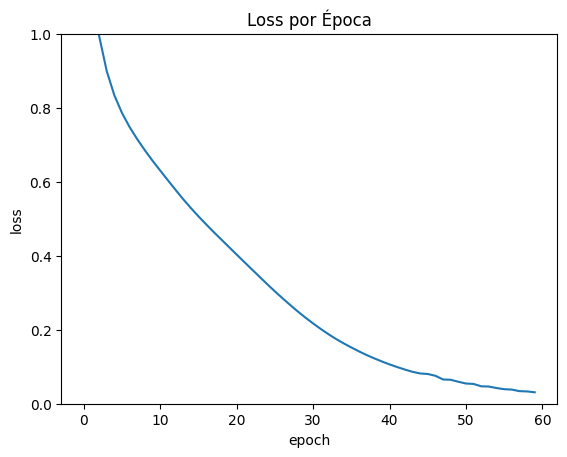

In [116]:
import matplotlib.pyplot as plt  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_set = TrajDataSet(signals_all)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)

num_epochs = 60
cout = [] 

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        inputs = batch.to(device)
        inputs = pad_to_multiple(inputs, multiple=16) 
    
        target = inputs[:, 1:2, :, :]
        
        outputs = model(inputs[:, 0:1, :, :])
        
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    cout.append(avg_loss) 
    # print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.6f}")
    
    if avg_loss < 0.01:
        torch.save(model.state_dict(), f"./checkpoints/Model_epoch_{epoch+1}.pt")

plt.figure()
plt.plot(cout)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.title("Loss por Época")
plt.show()

In [123]:
PATH='./checkpoints/Model_epoch_60.pt'

checkpoint = torch.load(PATH,map_location=torch.device('cpu'))

model.load_state_dict(checkpoint)
model.eval()
model = model.double()

In [149]:
I_C_cuda = pad_to_multiple(torch.from_numpy(I_C_nrml).double(), multiple=16).to(dev)
T_C_reg = model(I_C_cuda.reshape((1, 1, I_C_cuda.shape[0], I_C_cuda.shape[0])))

T_C_reg = denormalise(T_C_reg, mTc, sTc)
T_C_reg = crop_to_shape(T_C_reg, 30)
resids = T_C - T_C_reg

In [174]:
I_H_nrml = normalise(I_H)

I_H_cuda = pad_to_multiple(torch.from_numpy(I_H_nrml).double(), multiple=16).to(dev)
T_H_reg = model(I_H_cuda.reshape((1, 1, I_H_cuda.shape[0], I_H_cuda.shape[0])))

In [175]:
mIh = np.mean(I_H)
sIh = np.std(I_H)

In [176]:
T_H_reg = denormalise(T_H_reg, mIh, sIh)

In [177]:
T_H_reg = crop_to_shape(T_H_reg, 150)

In [178]:
deep_sharp_rc_linear = T_H_reg + upscale_coarse(resids)

In [ ]:
rmse(T_H_reg, T_H)

np.float64(105624.43082227407)

In [173]:
rmse(T_C_reg, T_C)

np.float64(0.006615525371318874)

In [ ]:
I_C_cuda = pad_to_multiple(torch.from_numpy(I_C).double(), multiple=16).to(dev)
model = model.double()
deep_sharp = model(I_C_cuda.reshape((1, 1, 32, 32)))

In [91]:
T_C_reg.cpu().detach().numpy()

array([[[[-0.35525182, -0.20307944,  0.04894751, ..., -0.83365478,
          -0.06826729, -0.01869535],
         [-0.46965031, -1.12437548, -1.14670951, ..., -1.21229923,
           0.00556562,  0.05729209],
         [-0.76859962, -1.65902644, -1.68757354, ..., -0.00379402,
          -0.0526891 ,  0.1229857 ],
         ...,
         [-0.41556358,  0.48447558,  0.13003828, ..., -0.37211916,
          -0.05329185,  0.00398062],
         [-0.0336599 ,  0.02869183,  0.0065005 , ..., -0.08244259,
           0.08434405, -0.01143817],
         [-0.0393939 , -0.07913225,  0.02542094, ..., -0.09391892,
          -0.15902947, -0.03053162]]]], shape=(1, 1, 32, 32))

In [ ]:



#I=I_C_cuda.detach().numpy()*sIc + mIc

plt.plot(I_C*sIc + mIc,T_C_reg*sTc + mTc,'k.')
plt.scatter(I_C*sIc + mIc,T_C*sTc + mTc,s=1,c='blue')
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:

x = np.linspace(I_C.min(), I_C.max(), 1000)
y = a1 * x + a0

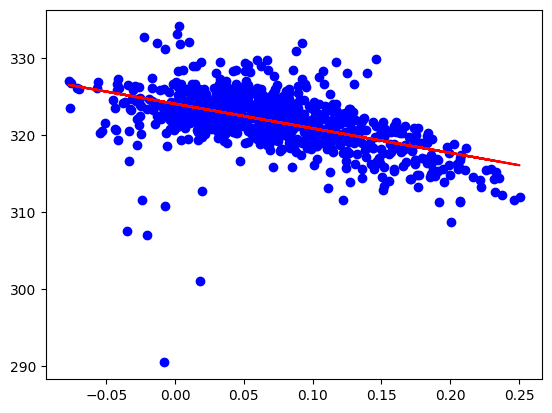

In [47]:
plt.plot(I_C.flatten(), T_C.flatten(), 'bo')
_ = plt.plot(I_C, I_C*a1 + a0, color='red')

<font size="2">**Sharpening**<font>
    
Generate a first estimate of the LST image at fine resolution. To do this define a function linear_sharpening

In [48]:
def linear_sharpening(index, slope, intercept):
    return index * slope + intercept

Plot this first estimate of LST map

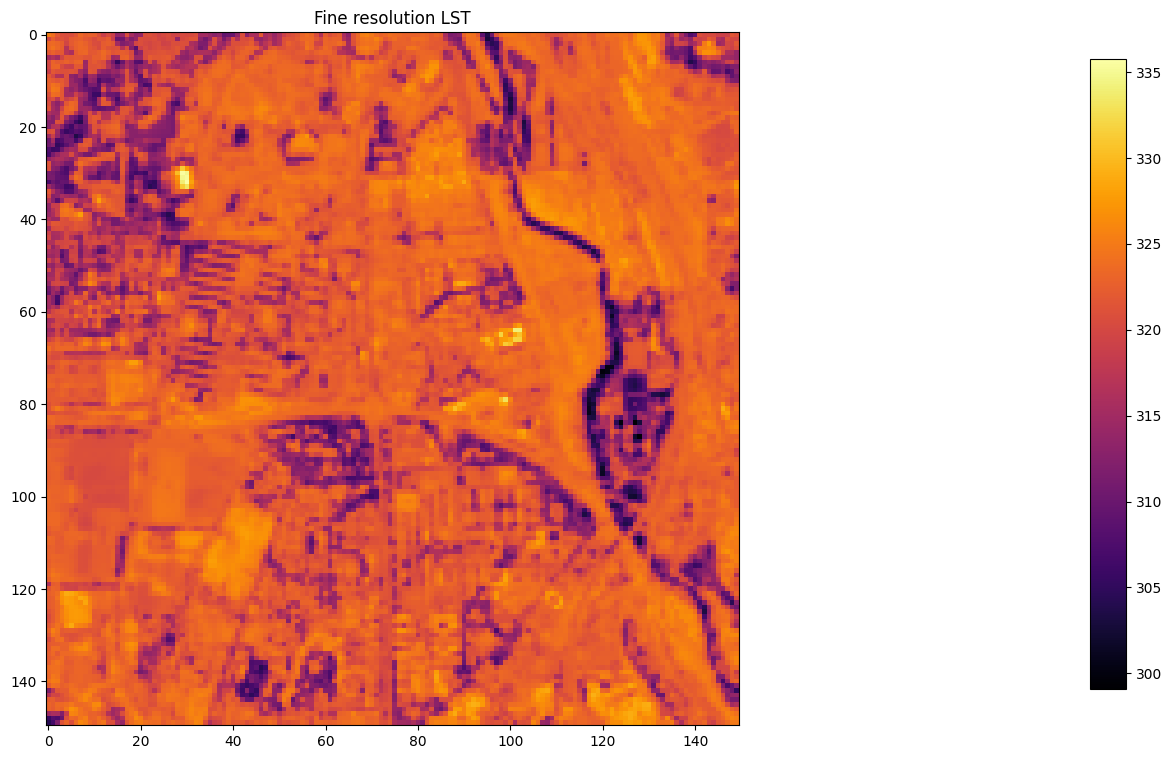

In [13]:
# T_sharp_temp = linear_sharpening(I_H, a1, a0)

fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(18, 9))

ax0.set_title('Fine resolution LST')
img=ax0.imshow(linear_classed, cmap='inferno')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar=fig.colorbar(img, cax=cbar_ax)

plt.show()

<font size="2">**Residual Correction**<font>
    
Generate a final LST estimation by performing a residual correction on the precedent one. Write a function correction_linreg that provides the residual correction Delta_T_final

In [50]:
T_L_delta = T_C - (I_C * a1 + a0)
T_L_delta.shape

(30, 30)

In [ ]:
import numpy as np






In [55]:
coarse_residuals = T_C - (I_C * a1 + a0)

fine_residuals_linear = get_fine_residuals_linear(coarse_residuals)
fine_residuals_krig = get_fine_residuals_krig(coarse_residuals)

T_H_hat_linear = T_sharp_temp + fine_residuals_linear
T_H_hat_krig = T_sharp_temp + fine_residuals_krig

Plot together the coarse LST and the final fine scale LST

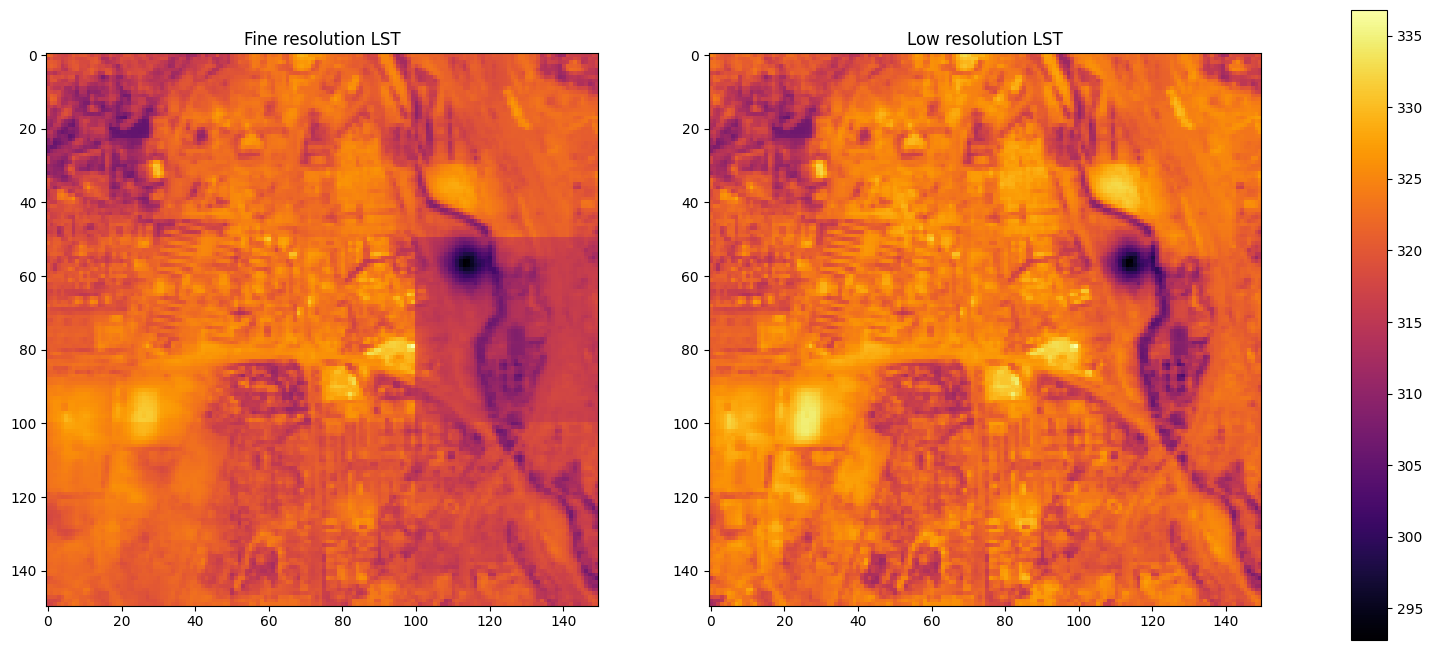

In [68]:
### TO DO
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(18, 9))

axs[0].set_title('Fine resolution LST')
img1=axs[0].imshow(reconstruct + fine_residuals_krig, cmap='inferno')

axs[1].set_title('Low resolution LST')
img2=axs[1].imshow(T_H_hat_krig, cmap='inferno')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar=fig.colorbar(img1, cax=cbar_ax)
cbar=fig.colorbar(img2, cax=cbar_ax)

plt.show()

Load the ground truth LST and compare it to the coarse scale LST the non corrected fine scale LST and the final product.

In [ ]:
path_temperature_h = 'data/LST_20m.img'

################### Temperature H ######################################

with rasterio.open(path_temperature_h) as dataset:
    T_H = dataset.read(1).astype(np.float32) 
    cols = dataset.width
    rows = dataset.height

# We can compute for example the RMSE

RMSE_GT_C = np.mean((T_C_resized - T_H) ** 2)
RMSE_GT_NC = np.mean((T_sharp_temp - T_H) ** 2)
rmse_linear = np.mean((T_H_hat_linear - T_H) ** 2)
rmse_krig = np.mean((T_H_hat_krig - T_H) ** 2)



print('RMSE with coarse scale', RMSE_GT_C)
print('RMSE with non corrected', RMSE_GT_NC)
print('RMSE with final product', rmse_linear)
print('RMSE with final product', rmse_krig)

RMSE with coarse scale 103573.2578543093
RMSE with non corrected 21.57698980437802
RMSE with final product 9.177208550747284
RMSE with final product 9.741766828649471


Plot the sharpened fine scale LST in function of the fine scale VI and the corresponding linear regression. Plot also the true fine scale LST in function of the fine scale VI and the coarse scale LST in function of the coarse scale VI.

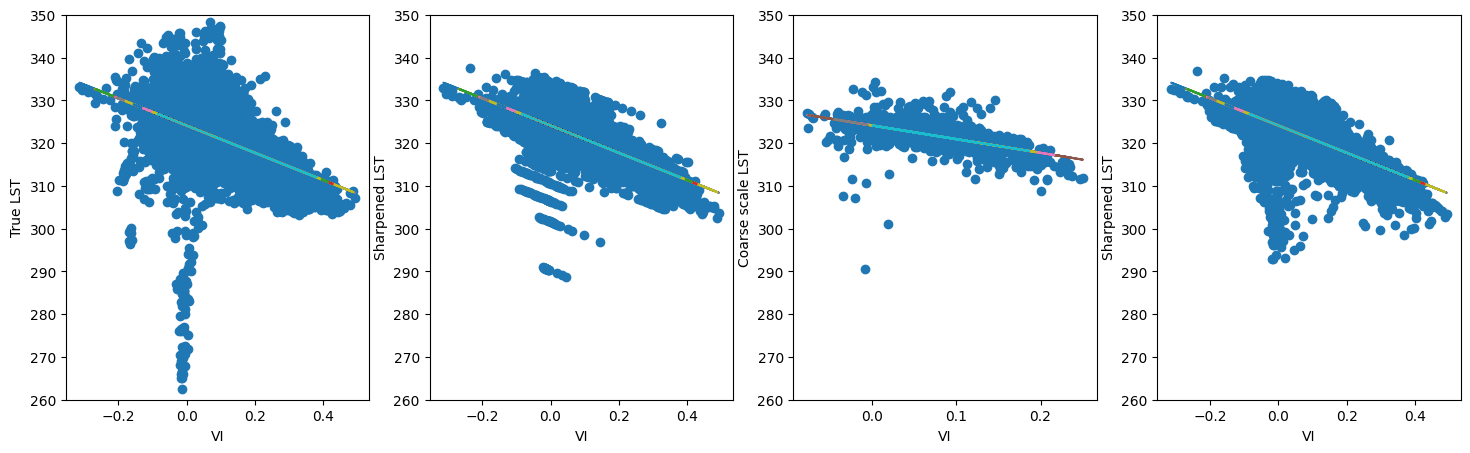

In [72]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharex=False, figsize=(18, 5))

### TO DO
ax0.scatter(I_H,T_H)
ax0.plot(I_H,a1*I_H+a0)
ax0.set_xlabel('VI')
ax0.set_ylabel('True LST')
ax0.set_ylim((260,350))

### TO DO
ax1.scatter(I_H,T_H_hat)
ax1.plot(I_H,a1*I_H+a0)
ax1.set_xlabel('VI')
ax1.set_ylabel('Sharpened LST')
ax1.set_ylim((260,350))

### TO DO
ax2.scatter(I_C,T_C)
ax2.plot(I_C,a1*I_C+a0)
ax2.set_xlabel('VI')
ax2.set_ylabel('Coarse scale LST')
ax2.set_ylim((260,350))

### TO DO
ax3.scatter(I_H,T_H_hat2)
ax3.plot(I_H,a1*I_H+a0)
ax3.set_xlabel('VI')
ax3.set_ylabel('Sharpened LST')
ax3.set_ylim((260,350))

plt.show()

Text(0, 0.5, 'Sharpened LST')

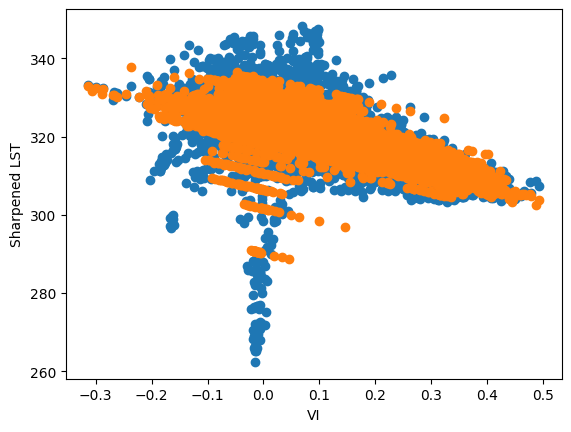

In [33]:
import matplotlib.pyplot as plt

plt.scatter(I_H,T_H)
plt.scatter(I_H,linear_sharp_rc_linaer)
plt.xlabel('VI')
plt.ylabel('Sharpened LST')
#ax3.set_ylim((260,350))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetResidual(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        out = self.final(d1)
        return out


In [41]:
import numpy as np
import math
from scipy.optimize import minimize

def round_to_nearest(value, step):
    return round(value / step) * step

def gamma_eta_eta(s, sill, range_):
    return sill * (1 - np.exp(-s / (range_ / 3)))

def empirical_gamma_L(s, xL_0_coord, delta_xL_0, xL_coords, delta_TL, s_tolerance=1e-3):
    N = len(xL_coords)
    distances = [
        np.linalg.norm(np.array(xL_0_coord) - np.array(xL_coord)) for xL_coord in xL_coords
    ]
    mask = np.abs(np.array(distances) - s) < s_tolerance

    sum_sq_diff = 0
    count = 0

    for i, is_distance in enumerate(mask):
        if is_distance:
            diff = delta_xL_0 - delta_TL[i]
            sum_sq_diff += diff ** 2
            count += 1

    if count == 0:
        return 0
    return sum_sq_diff / (2 * count)

def objective_sill_range(params, gamma_L_s, s_mm_s_arr, s_mm_0_arr, sigma_star):
    sill, range_ = params

    gamma_sum_s = np.sum([
        gamma_eta_eta(s_mm_s, sill, range_) for s_mm_s in s_mm_s_arr
      ])
    gamma_sum_0 = np.sum([
        gamma_eta_eta(s_mm_0, sill, range_) for s_mm_0 in s_mm_0_arr
    ])

    return (gamma_L_s - (1 / sigma_star) * (gamma_sum_s - gamma_sum_0)) ** 2

def compute_gamma_etaL(x_eta_coords, xL_fine_coords, sill, range_):
    sigma = len(xL_fine_coords)
    s_m = [np.linalg.norm(x_eta_coords - xLf) for xLf in xL_fine_coords]
    return (1 / sigma) * sum(gamma_eta_eta(s, sill, range_) for s in s_m)

def compute_gamma_LL(xL_i_fine_coords, xL_j_fine_coords, sill, range_):
    sigma = len(xL_i_fine_coords)
    gamma_sum = 0
    for m in range(sigma):
        for m1 in range(sigma):
            s = np.linalg.norm(xL_i_fine_coords[m] - xL_j_fine_coords[m1])
            gamma_sum += gamma_eta_eta(s, sill, range_)
    return gamma_sum / (sigma ** 2)

def solve_kriging_system(gamma_LL_matrix, gamma_etaL_vector):
    N = gamma_LL_matrix.shape[0]
    A = np.zeros((N + 1, N + 1))
    A[:N, :N] = gamma_LL_matrix
    A[:N, -1] = 1
    A[-1, :N] = 1
    A[-1, -1] = 0

    b = np.append(gamma_etaL_vector, 1)

    solution = np.linalg.solve(A, b)
    lambdas = solution[:-1]
    theta = solution[-1]
    return lambdas, theta


def get_high_res_pixels(coarse_pixel, high_res_image, scaling_factor=5):
    i, j = coarse_pixel

    high_res_block = high_res_image[
        i * scaling_factor : (i + 1) * scaling_factor,
        j * scaling_factor : (j + 1) * scaling_factor
    ]
    return high_res_block

def get_fine_pixels_from_coarse(coarse_pixel, scale = 5):
    i_c, j_c = coarse_pixel

    i_start = i_c * scale
    j_start = j_c * scale

    fine_pixels = [(i, j) for i in range(i_start, i_start + scale)
                          for j in range(j_start, j_start + scale)]
    return fine_pixels

def get_closest_pixels(image, pixel, N):
    i, j = pixel
    rows, cols = image.shape

    if i < 0 or i >= rows or j < 0 or j >= cols:
        raise ValueError("Pixel coordinates are out of bounds.")

    # Generate all possible pixel coordinates
    y_coords, x_coords = np.mgrid[0:rows, 0:cols]
    coordinates = np.column_stack((y_coords.ravel(), x_coords.ravel()))  # All (i,j) pairs

    # Compute Euclidean distances from the target pixel
    distances = np.sqrt((coordinates[:, 0] - i) ** 2 + (coordinates[:, 1] - j) ** 2)

    # Sort pixels by distance and get the first N
    sorted_indices = np.argsort(distances)
    closest_indices = sorted_indices[:N]
    closest_pixels = coordinates[closest_indices]

    # Get corresponding pixel values
    pixel_values = [image[y, x] for y, x in closest_pixels]

    return closest_pixels, pixel_values

def get_pixel_pairs_at_distance(coords, target_dist, tolerance=1e-3):
    pairs = []
    n = len(coords)
    for i in range(n):
        for j in range(n):
            if target_dist == 0:
                if i == j:
                    pairs.append((coords[i], coords[j]))
            elif i < j:  # avoid duplicates for non-zero distances
                dist = math.dist(coords[i], coords[j])
                if abs(dist - target_dist) <= tolerance:
                    pairs.append((coords[i], coords[j]))
    return pairs

In [42]:
T_H_hat.shape, T_C.shape

((150, 150), (30, 30))

In [54]:

empirical_gamma_Ls = {}
gamma_eta_eta_sills_and_ranges = {}


def get_s_distances(s, x_L_coords):
    res = get_pixel_pairs_at_distance(x_L_coords, s)
    distances = []
    for (x_L_i, x_L_j) in res:
      x_L_i_fine_pixels = get_fine_pixels_from_coarse(x_L_i)
      x_L_j_fine_pixels = get_fine_pixels_from_coarse(x_L_j)

      for m in x_L_i_fine_pixels:
        for m_ in x_L_j_fine_pixels:
          distances.append(
              np.linalg.norm(np.array(m) - np.array(m_))
          )
    return distances

def solve_for_sill_and_range(s_m, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta, sigma=5):
    gamma_L_s_m = get_gamma_L_s(s_m, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta.flatten())
    distances_s_mm  = get_s_distances(s_m, x_L_coords)
    distances_0_mm = get_s_distances(0, x_L_coords)

    sigma_star = len(distances_s_mm) * sigma ** 2

    min_res = minimize(
        lambda x: objective_sill_range(x, gamma_L_s_m, distances_s_mm, distances_0_mm, sigma_star),
        x0=(0.1, 0.1)
    )
    sill, range = min_res.x
    return sill, range


def calculate_gamma_eta_L(x_eta_coords, x_L_j_coords, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta):
    x_L_j_fine_pixels_coords = get_fine_pixels_from_coarse(x_L_j_coords)
    s_ms = [
        np.linalg.norm(x_eta_coords - np.array(x_L_j_coord))
        for x_L_j_coord in x_L_j_fine_pixels_coords
    ]
    sum = 0
    for s_m in s_ms:
       sum += get_gamma_eta_eta(s_m, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta)
    return sum

def get_gamma_L_s(s, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta):
    if s not in empirical_gamma_Ls:
        empirical_gamma_Ls[s] = empirical_gamma_L(s, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta)
    return empirical_gamma_Ls[s]

def get_gamma_eta_eta(s, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta):
    if s not in gamma_eta_eta_sills_and_ranges:
        gamma_eta_eta_sills_and_ranges[s] = solve_for_sill_and_range(s, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta)
    return gamma_eta_eta(s, *gamma_eta_eta_sills_and_ranges[s])
        

In [45]:
x_L_coords = [(i,j) for i in range(30) for j in range(30)]

x_L_0_coord = (0 ,0)
delta_x_L_0 = T_L_delta[x_L_0_coord]



x_L_i_coord = (0 ,0)
detla_x_L_i = T_L_delta[x_L_i_coord]

N = 25
n_closeset_coarse_coords, n_closest_coarse_values = get_closest_pixels(T_L_delta, x_L_i_coord, N)

fine_pixel_coords = get_fine_pixels_from_coarse(x_L_i_coord)
x_etas = [T_H_hat[i, j] for (i, j) in fine_pixel_coords]

In [46]:
x_eta_coords = fine_pixel_coords[0]
x_eta = T_H_hat[x_eta_coords]

In [ ]:
x_L_j_coords = n_closeset_coarse_coords[0]


In [55]:
res = calculate_gamma_eta_L(x_eta_coords, x_L_j_coords, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta)

KeyboardInterrupt: 

In [ ]:

# z_fine is now your interpolated fine-resolution image
